In [3]:
# !conda install -c conda-forge lightgbm

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from patsy import dmatrices # helps format the input and target variables for ML

# import specific functions from the machine learning library, "sklearn"
from sklearn import svm, neighbors, tree, linear_model
from sklearn.model_selection import RepeatedKFold, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic

import seaborn as sns
sns.set(style='white')

In [3]:
# read data from the .csv file

df = pd.read_csv("am_measurement_data.csv")
df.head()

,print_serial,design,print_location,hardware,layout,material,color,feature_category,feature_class,feature_id,feature_category_class,material_color,part_id,print_x_mm,print_y_mm,CAD_mm,measure_mm,DFT_mm,print_dist_from_origin_mm,thermal_cure
0,KR70035C,bracket,7,1,1,EPX,black,center,dist_length,bracket_dist_mm_c,center_dist_length,EPX_black,KR70035C_7,42,48,15.0,14.969881,-0.030119,63.780875,True
1,KR70035C,bracket,7,1,1,EPX,black,height,height,bracket_height_mm,height_height,EPX_black,KR70035C_7,42,48,8.0,7.644579,-0.355421,63.780875,True
2,KR70035C,bracket,7,1,1,EPX,black,inner,dia,bracket_inner_dia_mm_a,inner_dia,EPX_black,KR70035C_7,42,48,2.5,2.404393,-0.095607,63.780875,True
3,KR70035C,bracket,7,1,1,EPX,black,inner,length,bracket_inner_length_mm_b,inner_length,EPX_black,KR70035C_7,42,48,15.0,14.928239,-0.071761,63.780875,True
4,KR70035C,bracket,7,1,1,EPX,black,outer,thick,bracket_thick_mm_a,outer_thick,EPX_black,KR70035C_7,42,48,2.0,1.995835,-0.004165,63.780875,True


In [4]:
print(df.columns)

Index(['print_serial', 'design', 'print_location', 'hardware', 'layout',
       'material', 'color', 'feature_category', 'feature_class', 'feature_id',
       'feature_category_class', 'material_color', 'part_id', 'print_x_mm',
       'print_y_mm', 'CAD_mm', 'measure_mm', 'DFT_mm',
       'print_dist_from_origin_mm', 'thermal_cure'],
      dtype='object')


In [5]:
# Define the target (y) variable and the input (x) variables
# Notice "dmatrices" one-hot-encodes categorical variables for us 

y, x = dmatrices('DFT_mm ~ CAD_mm + print_x_mm + print_y_mm + print_dist_from_origin_mm + C(material) + C(hardware) + C(feature_category) + C(feature_class)', df, return_type="dataframe")
y.head()    # target variable to be predicted

,DFT_mm
0,-0.030119
1,-0.355421
2,-0.095607
3,-0.071761
4,-0.004165


In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state = 2022)

In [7]:
np.array(y_train).flatten().shape

(1620,)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
mc = MinMaxScaler()
x_train = sc.fit_transform(x_train).astype("float32")
x_test = sc.transform(x_test).astype("float32")

In [9]:
sampling_fractions = np.arange(0.1, 1, 0.1) # 10-90% in 20% increments
test_fractions = [0.1] * 9                  # 10% for all
outer_folds = 50                             # dual Monte Carlo subsampling CV
inner_folds = 3                             # inner k-fold CV with Grid Search
svr_nested_cv_results = pd.DataFrame()      # empty dataframe for storing results

## K-Nearest Neighbors ##

In [11]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# KNN - k-nearest neighbors
# using the same train/test fractions and number of loops as with SVR

knn_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
    
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('knn', neighbors.KNeighborsRegressor())]),
            param_grid={
                'knn__n_neighbors': np.arange(2, 9, 2),
                'knn__metric': ["chebyshev", "euclidean", "manhattan"]
            },
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # knn_nested_cv_results = knn_nested_cv_results.append(inner_kfcv_results)
        knn_nested_cv_results = pd.concat([knn_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## Support Vector Regression ##

In [12]:
for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('svr', svm.SVR())]),
            param_grid={
                'svr__kernel': ['rbf'],
                'svr__gamma': ['scale', 'auto'],
                'svr__epsilon': [0.01, 0.02, 0.03],
            },
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # svr_nested_cv_results = svr_nested_cv_results.append(inner_kfcv_results)
        svr_nested_cv_results = pd.concat([svr_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## Decision Trees ##

In [13]:
# Decision Tree
# using the same train/test fractions and number of loops as with SVR

tree_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('tree', tree.DecisionTreeRegressor())]),
            param_grid={
                'tree__max_depth': np.arange(4, 9, 2),
                # 'tree__criterion': ["squared_error", "absolute_error", "friedman_mse"]  # does not work in scikit.__version__ 0.24, but does in __version__ 1.0
                'tree__criterion': ["friedman_mse"]
            },
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # tree_nested_cv_results = tree_nested_cv_results.append(inner_kfcv_results)
        tree_nested_cv_results = pd.concat([tree_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## Random Forest ##

In [15]:
# Random Forest
# using the same train/test fractions and number of loops as with RF

rf_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())]),
            param_grid = {
                    'rf__bootstrap': [True],
                    'rf__max_depth': [100, 110],
                    'rf__max_features': [2, 3],
                    'rf__min_samples_leaf': [3, 4],
                    'rf__min_samples_split': [8, 10, 12],
                    'rf__n_estimators': [100, 200, 300]},
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # rf_nested_cv_results = rf_nested_cv_results.append(inner_kfcv_results)
        rf_nested_cv_results = pd.concat([rf_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## Gradient Boosting Machine ##

In [17]:
# Gradient Boosting Machine
# using the same train/test fractions and number of loops as with GBM

gbm_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('gbm', GradientBoostingRegressor())]),
            param_grid = {
                    "gbm__loss": ["squared_error", "absolute_error"],
                    "gbm__n_estimators": [50, 100, 200, 500],
                    "gbm__max_leaf_nodes": [10, 20, 50, 100],
                    "gbm__learning_rate": [0.1, 0.3, 0.5]},
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # gbm_nested_cv_results = gbm_nested_cv_results.append(inner_kfcv_results)
        gbm_nested_cv_results = pd.concat([gbm_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## XGBoost ##

In [18]:
# Xtreme Gradient Boosting Machine
# using the same train/test fractions and number of loops as with XGBM

xgbm_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('xgbm', XGBRegressor())]),
            param_grid = {
                'xgbm__learning_rate': [0.05, 0.1, 0.3, 0.5],
                'xgbm__max_depth': [3, 5, 7, 10],
                'xgbm__subsample': [0.5, 0.7, 0.9],
                'xgbm__n_estimators' : [100, 200, 500],
            },
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # xgbm_nested_cv_results = xgbm_nested_cv_results.append(inner_kfcv_results)
        xgbm_nested_cv_results = pd.concat([xgbm_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## AdaBoost

In [35]:
# # Adaptive Gradient Boosting Machine
# # using the same train/test fractions and number of loops as with AdaGBM

# adaboost_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

# for sf, tf in zip(sampling_fractions, test_fractions):
#     print("Sampling Fraction: {:.1f}".format(sf))
#     rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
#     for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
#         # outer data split into test/train/unused sets
#         unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
#         x_train = x.loc[train_idx]
#         y_train = y.loc[train_idx]
#         x_test = x.loc[test_idx]
#         y_test = y.loc[test_idx]

#         # inner k-fold CV loop with automated grid search hyperparameter tuning
#         kfcv = GridSearchCV(
#             estimator=Pipeline([('scaler', StandardScaler()), ('adaboost', AdaBoostRegressor())]),
#             param_grid = {
#                 "adaboost__loss": ['linear', 'square', 'exponential'],
#                 "adaboost__n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
#                 "adaboost__learning_rate": [0.01, 0.05, 0.3, 0.5, 0.7],
#                 },
#             scoring='neg_root_mean_squared_error',
#             cv=inner_folds,
#             n_jobs=-1,
#         )
#         kfcv.fit(x_train, np.ravel(y_train))
#         results_df = pd.DataFrame(kfcv.cv_results_)
#         best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

#         # record data so we can access it outside the loop
#         inner_kfcv_results = pd.DataFrame(
#             data={
#                 'iter': iter,
#                 'sf': sf,
#                 'tf': tf,
#                 "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
#                 'train_score': [kfcv.score(x_train, y_train)],  # training score
#                 'test_score': [kfcv.score(x_test, y_test)],     # testing score
#             }
#         )
#         adaboost_nested_cv_results = adaboost_nested_cv_results.append(inner_kfcv_results)

## Light GBM ##

In [32]:
# Light Gradient Boosting Machine
# using the same train/test fractions and number of loops as with LGBM

lgbm_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('lgbm', lgb.LGBMRegressor())]),
            param_grid = {
              'lgbm__learning_rate': [0.01, 0.1, 0.3],
              'lgbm__n_estimators': [50, 100, 150],
              'lgbm__max_depth': [3, 5, 7, 10],
              'lgbm__colsample_bytree': [0.7, 0.8, 0.9],
              'lgbm__subsample': [0.7, 0.8, 0.9],
              'lgbm__min_child_samples': [1, 5, 10]
              },
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        lgbm_nested_cv_results = lgbm_nested_cv_results.append(inner_kfcv_results)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


## MLP Regressor ##

In [20]:
# MLP Regressor
# using the same train/test fractions and number of loops as with MLP Regressor

mlp_nested_cv_results = pd.DataFrame()  # empty dataframe for storing results

for sf, tf in zip(sampling_fractions, test_fractions):
    print("Sampling Fraction: {:.1f}".format(sf))
    rsh = ShuffleSplit(n_splits=outer_folds, train_size=sf, test_size=tf, random_state=2022)
    for iter, (train_idx, test_idx) in enumerate(rsh.split(x)):
        
        # outer data split into test/train/unused sets
        unused_idx = np.asarray([j for j in np.arange(x.shape[0]) if j not in train_idx and j not in test_idx])
        x_train = x.loc[train_idx]
        y_train = y.loc[train_idx]
        x_test = x.loc[test_idx]
        y_test = y.loc[test_idx]

        # inner k-fold CV loop with automated grid search hyperparameter tuning
        kfcv = GridSearchCV(
            estimator=Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor())]),
            param_grid = {
                'mlp__hidden_layer_sizes': [(7,7,7), (24,16,8), (48,24,8)],
                'mlp__max_iter': [10000, 15000, 20000],
                'mlp__activation': ['tanh', 'relu', 'logistic'],
                'mlp__solver': ['sgd', 'adam', 'lbfgs'],
                'mlp__learning_rate': ['constant','adaptive'],
                },
            scoring='neg_root_mean_squared_error',
            cv=inner_folds,
            n_jobs=-1,
        )
        kfcv.fit(x_train, np.ravel(y_train))
        results_df = pd.DataFrame(kfcv.cv_results_)
        best_result = results_df[results_df.rank_test_score == 1]   # Note there can be a tie

        # record data so we can access it outside the loop
        inner_kfcv_results = pd.DataFrame(
            data={
                'iter': iter,
                'sf': sf,
                'tf': tf,
                "inner_kfold_valid_score": [kfcv.best_score_],  # inner validation score
                'train_score': [kfcv.score(x_train, y_train)],  # training score
                'test_score': [kfcv.score(x_test, y_test)],     # testing score
            }
        )
        # mlp_nested_cv_results = mlp_nested_cv_results.append(inner_kfcv_results)
        mlp_nested_cv_results = pd.concat([mlp_nested_cv_results, inner_kfcv_results], ignore_index=True)

Sampling Fraction: 0.1
Sampling Fraction: 0.2
Sampling Fraction: 0.3
Sampling Fraction: 0.4
Sampling Fraction: 0.5
Sampling Fraction: 0.6
Sampling Fraction: 0.7
Sampling Fraction: 0.8
Sampling Fraction: 0.9


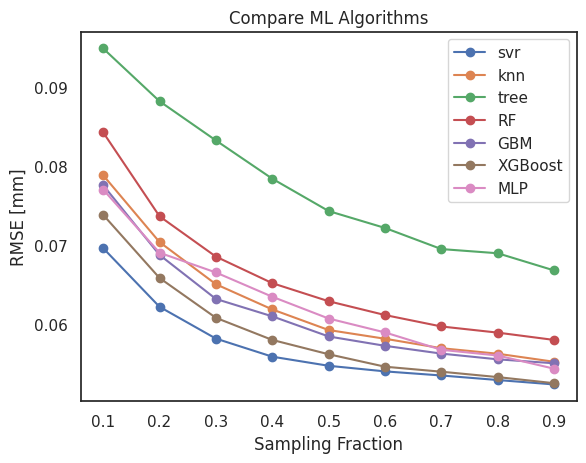

In [22]:
# Compute the average score for the three ML algorithms at each sf/tf combination

svr_data_avg = svr_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
knn_data_avg = knn_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
tree_data_avg = tree_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
rf_data_avg = rf_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
gbm_data_avg = gbm_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
xgbm_data_avg = xgbm_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
# adaboost_data_avg = adaboost_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
lgbm_data_avg = lgbm_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
mlp_data_avg = mlp_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()

# Plot the results to compare predictive performance
plt.plot(svr_data_avg.sf, -svr_data_avg.test_score, '-o', label="svr")
plt.plot(knn_data_avg.sf, -knn_data_avg.test_score, '-o', label="knn")
plt.plot(tree_data_avg.sf, -tree_data_avg.test_score, '-o', label="tree")
plt.plot(rf_data_avg.sf, -rf_data_avg.test_score, '-o', label="RF")
plt.plot(gbm_data_avg.sf, -gbm_data_avg.test_score, '-o', label="GBM")
plt.plot(xgbm_data_avg.sf, -xgbm_data_avg.test_score, '-o', label="XGBoost")
# plt.plot(adaboost_data_avg.sf, -adaboost_data_avg.test_score, '-o', label="AdaBoost")
plt.plot(lgbm_data_avg.sf, -lgbm_data_avg.test_score, '-o', label="LGBM")
plt.plot(mlp_data_avg.sf, -mlp_data_avg.test_score, '-o', label="MLP")

plt.title('Compare ML Algorithms')
plt.xlabel("Sampling Fraction")
plt.ylabel("RMSE [mm]")
plt.legend()
plt.show()

In [38]:
from matplotlib import rc
from matplotlib import rcParams

fontsize = 32

plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize) 
rc('ytick', labelsize=fontsize) 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

fig, ((ax)) = plt.subplots(ncols=1, nrows=1, figsize=(15,12), dpi=600)

fontsize = 32

plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize) 
rc('ytick', labelsize=fontsize) 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

# Compute the average score for the three ML algorithms at each sf/tf combination

svr_data_avg = svr_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
knn_data_avg = knn_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
tree_data_avg = tree_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
rf_data_avg = rf_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
gbm_data_avg = gbm_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
xgbm_data_avg = xgbm_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
# adaboost_data_avg = adaboost_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
lgbm_data_avg = lgbm_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()
mlp_data_avg = mlp_nested_cv_results.groupby(by=['sf', 'tf'], as_index=False).mean()

cmap = sns.color_palette()

# Plot the results to compare predictive performance
ax.plot(svr_data_avg.sf, -svr_data_avg.test_score, '-o', linestyle='solid', linewidth=2, label="$SVR$")
ax.plot(knn_data_avg.sf, -knn_data_avg.test_score, '-o', linestyle='dashed', label="$kNN$")
ax.plot(tree_data_avg.sf, -tree_data_avg.test_score, '-o', linestyle='dashed',color='magenta', label="$Tree$")
ax.plot(rf_data_avg.sf, -rf_data_avg.test_score, '-o', linestyle='dashed', color='red', label="$RF$")
ax.plot(gbm_data_avg.sf, -gbm_data_avg.test_score, '-o', linestyle='dashed', color='lime', label="$GBM$")
ax.plot(xgbm_data_avg.sf, -xgbm_data_avg.test_score, '-o', color='green', linestyle='solid', linewidth=2, label="$XGBoost$")
# ax.plot(adaboost_data_avg.sf, -adaboost_data_avg.test_score, '-o', label="AdaBoost")
ax.plot(lgbm_data_avg.sf, -lgbm_data_avg.test_score, '-o', color='magenta', linestyle='dashed', linewidth=2, label="$LGBM$")
ax.plot(mlp_data_avg.sf, -mlp_data_avg.test_score, '-o', linestyle='dashed', color='darkviolet', label="$MLP$")

ax.set_ylabel(r'$RMSE$ $[mm]$', fontweight ='bold', fontsize=fontsize)
ax.set_xlabel(r'$Sampling$ $Fraction$ (% $Train$)', fontweight ='bold', fontsize=fontsize)
ax.set_xlim([0.05,1])
ax.set_ylim([0.05,0.1])
plt.tick_params(left = True, right = True, top= True, bottom= True, which = 'both')
ax.legend(fontsize=28)
plt.savefig("plots/Comparison_ML_models_WO_LGBM.png")
plt.show()